# Key words exploration

The objective of this section is to explore reviews in an attempt to find common needs for travellers with special needs
The procedure is as follows:
1. For each category, perform TF-IDF to identify the most symbolic words in the reviews
2. To better identify discriminatory words, remove some of the common words using a ratio system

In [ ]:
import polars as pl
import torch
torch.set_num_threads(4)
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
from tqdm import tqdm
import spacy
from typing import List
from stop_words import get_stop_words
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import NMF


## Retrieve reviews related to special needs

After compiling relevant datasets, the cleaned reviews must be retrieved to perform statistical analysis.

### Load reviews cleaned

In [67]:
def process_category(category_name: str, df_kw_path: str, df_final_path_template: str, output_path_template: str):
    """
    Process reviews for a given category:
    - load the final reviews
    - join with keywords
    - rename the cleaned review column
    - filter by category
    - write to CSV
    """
    # Load final reviews
    df_final = pl.read_csv(df_final_path_template.format(category=category_name))
    
    # Load keywords
    df_kw = pl.read_csv(df_kw_path)
    
    # Join on id
    df = df_final.join(df_kw, left_on="id", right_on="id", how="left")
    
    # Rename column
    df = df.rename({"review_right": "review_cleaned"})
    
    # Filter by category
    df = df.filter(pl.col("category") == category_name)
    
    # Write CSV
    df.write_csv(output_path_template.format(category=category_name))
    print(f"Processed category '{category_name}' -> {output_path_template.format(category=category_name)}")

# Paramètres
categories = ["child", "pet", "handicap"]
df_kw_path = "../../data/processed/Bazarre/key_words_data_hotel_reviews_1.csv"
df_final_path_template = "../../data/processed/final/{category}/validated_data_hotel_reviews_1_{category}_good.csv"
output_path_template = "test_{category}.csv"

# Exécution
for cat in categories:
    process_category(cat, df_kw_path, df_final_path_template, output_path_template)


Processed category 'child' -> test_child.csv
Processed category 'pet' -> test_pet.csv
Processed category 'handicap' -> test_handicap.csv


### Merge all the categories in one csv

In [68]:
csv_files = [
    "test_child.csv",
    "test_pet.csv",
    "test_handicap.csv"
]

df_list = [pl.read_csv(f) for f in csv_files]
df = pl.concat(df_list)

print(f"Merged {len(csv_files)} CSV files into a single DataFrame with {df.shape[0]} rows.")

Merged 3 CSV files into a single DataFrame with 200 rows.


### Lemmatization of reviews

Statistical methods are based on word occurrence. To improve the robustness and consistency of the results, a lemmatization step of our reviews can/should be applied.

In [69]:
# Load spacy
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])


def lemmatize_and_clean_texts(
    texts: List[str],
    batch_size: int = 2000,
    n_process: int = 4
) -> List[str]:
    clean_texts = [(t if isinstance(t, str) else "") for t in texts]
    lemmatized = []
    for doc in nlp.pipe(clean_texts, batch_size=batch_size, n_process=n_process):
        text = " ".join([token.lemma_ for token in doc])
        text = text.replace(" - ", "-").strip()
        lemmatized.append(text)
    return lemmatized


def lemmatize_column_fast(
    df: pl.DataFrame, 
    col_name: str, 
    new_col_name: str = None, 
    chunk_size: int = 50000, 
    n_process: int = 4
) -> pl.DataFrame:
    new_col_name = new_col_name or f"{col_name}_lemmatized"
    texts = df.select(col_name).to_series().to_list()
    lemmatized_chunks = []

    for i in tqdm(range(0, len(texts), chunk_size), desc=f"Lemmatizing {col_name}"):
        chunk = texts[i:i + chunk_size]
        lemmatized_chunks.extend(lemmatize_and_clean_texts(chunk, n_process=n_process))

    return df.with_columns(pl.Series(name=new_col_name, values=lemmatized_chunks))

In [70]:
df = lemmatize_column_fast(df, col_name="review_cleaned", new_col_name="review_lemmatized")

Lemmatizing review_cleaned:   0%|          | 0/1 [00:00<?, ?it/s]

Lemmatizing review_cleaned: 100%|██████████| 1/1 [00:24<00:00, 24.69s/it]


## TF-IDF

TF-IDF (Term Frequency–Inverse Document Frequency) is a text-weighting method that highlights how important a word is within a document relative to a collection of documents. It works by combining how often a term appears in a document (TF) with how rare it is across the corpus (IDF). Common words receive low weights, while distinctive words get higher scores. This allows us to identify the most characteristic terms of each document or group of documents.

In [76]:
# Custom stop words
custom_stop_words = set(get_stop_words("en"))

extra_stop_words = {"didn"} 
custom_stop_words.update(extra_stop_words)
custom_stop_words = list(custom_stop_words)

vectorizer = TfidfVectorizer(stop_words=custom_stop_words, lowercase=True, max_features=1000)

### TD_IDF per category

In [77]:
#  TF-IDF analysis per category
categories_of_interest = ["handicap", "pet", "child"]

tfidf_per_category = {}

for cat in categories_of_interest:
    reviews_cat = df.filter(pl.col("category") == cat)["review_lemmatized"].to_list()
    if len(reviews_cat) == 0:
        continue

    X = vectorizer.fit_transform(reviews_cat)
    feature_names = vectorizer.get_feature_names_out()
    avg_tfidf = X.mean(axis=0).A1  
    tfidf_per_category[cat] = sorted(
        zip(feature_names, avg_tfidf),
        key=lambda x: x[1],
        reverse=True
    )


# Display top words per category
for cat in categories_of_interest:
    print(f"\nTop words for category '{cat}':")
    if cat in tfidf_per_category:
        for word, score in tfidf_per_category[cat][:10]:
            print(word, round(score, 3))
    else:
        print("No reviews in this category.")



Top words for category 'handicap':
stay 0.06
hotel 0.056
handicap 0.053
accessible 0.043
staff 0.04
floor 0.039
handicapped 0.037
pool 0.035
walk 0.035
bathroom 0.034

Top words for category 'pet':
pet 0.116
hotel 0.095
friendly 0.078
stay 0.071
dog 0.066
staff 0.054
clean 0.053
love 0.041
time 0.037
motel 0.036

Top words for category 'child':
hotel 0.074
stay 0.07
pool 0.061
family 0.06
kid 0.054
staff 0.053
clean 0.047
nice 0.036
friendly 0.036
breakfast 0.033


c:\Users\emma\Desktop\project\large-project\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ain', 'daren', 'hadn', 'herse', 'himse', 'itse', 'mayn', 'mightn', 'mon', 'mustn', 'myse', 'needn', 'oughtn', 'shan', 'vis'] not in stop_words.
  warnings.warn(


### TF-IDF compared to all categories

In [ ]:
all_reviews = df["review_lemmatized"].to_list()
vectorizer.fit(all_reviews)

tfidf_per_category = {}
for cat in categories_of_interest:
    reviews_cat = df.filter(pl.col("category") == cat)["review_lemmatized"].to_list()
    if not reviews_cat:
        continue
    X = vectorizer.transform(reviews_cat)             
    avg_tfidf = X.mean(axis=0).A1
    tfidf_per_category[cat] = sorted(zip(vectorizer.get_feature_names_out(), avg_tfidf),
                                     key=lambda x: x[1], reverse=True)
    
for cat in categories_of_interest:
    print(f"\nTop words for category '{cat}':")
    if cat in tfidf_per_category:
        for word, score in tfidf_per_category[cat][:10]:
            print(word, round(score, 3))
    else:
        print("No reviews in this category.")



Top words for category 'handicap':
handicap 0.077
accessible 0.056
handicapped 0.05
stay 0.046
floor 0.045
hotel 0.044
wheelchair 0.043
shower 0.041
bathroom 0.036
walk 0.035

Top words for category 'pet':
pet 0.171
dog 0.096
friendly 0.09
hotel 0.088
stay 0.071
staff 0.054
clean 0.048
motel 0.044
love 0.04
time 0.038

Top words for category 'child':
family 0.082
hotel 0.075
pool 0.075
kid 0.07
stay 0.07
staff 0.052
clean 0.049
nice 0.037
friendly 0.035
breakfast 0.033


### TD-IDF with ratio

This last script allows us to identify even more strictly the discriminant words for each category. The goal is simple: we want to find words that are very important in one category but insignificant in the others.
To do this, we use a ratio-based method with three parameters:

- TOP_K: only the top TOP_K most important words in the target category are considered, limiting the analysis to the most relevant terms.

- MIN_RANK: a word appearing in another category with a rank lower than MIN_RANK is considered too common elsewhere and therefore not discriminant.

- RATIO: the TF-IDF of the word in the target category must be at least RATIO times higher than its TF-IDF in any other category to be considered discriminant.

This way, only words that are both frequent and characteristic of a category are retained.

In [79]:
# Parameters
TOP_K = 80         # important words in a category
MIN_RANK = 200     # Maximum rank in the others to be considered insignificant
RATIO = 2.0        # ratio TF-IDF 


# Rank of each word in each category
rank_per_cat = {}
tfidf_value = {}

for cat, word_scores in tfidf_per_category.items():
    rank_per_cat[cat] = {}
    tfidf_value[cat] = {}

    for rank, (word, score) in enumerate(word_scores):
        rank_per_cat[cat][word] = rank
        tfidf_value[cat][word] = score



# Compute discriminant words
discriminant_words = defaultdict(list)

for cat in categories_of_interest:
    if cat not in tfidf_per_category:
        continue

    for (word, score) in tfidf_per_category[cat][:TOP_K]: 

        is_discriminant = True

        for other_cat in categories_of_interest:
            if other_cat == cat:
                continue

            # if word exists in other category
            if word in rank_per_cat[other_cat]:

                rank_other = rank_per_cat[other_cat][word]
                score_other = tfidf_value[other_cat][word]

                # condition 1 : not too high ranked in other categories
                if rank_other < MIN_RANK:
                    # condition 2 : apply ratio condition
                    if score <= RATIO * score_other:
                        is_discriminant = False
                        break

        if is_discriminant:
            discriminant_words[cat].append(word)


for cat in discriminant_words:
    print(f"\nDiscriminant words for '{cat}':")
    print(discriminant_words[cat][:20])
    print("Total:", len(discriminant_words[cat]))



Discriminant words for 'handicap':
['handicap', 'accessible', 'handicapped', 'floor', 'wheelchair', 'shower', 'bathroom', 'walk', 'elevator', 'parking', 'beach', 'request', 'chair', 'extremely', 'space', 'difficult', 'ice', 'person', 'hard', 'roll']
Total: 49

Discriminant words for 'pet':
['pet', 'dog', 'friendly', 'motel', 'feel', 'quiet', 'fee', 'super', 'coffee', 'fantastic', 'offer', 'town', 'allergic', 'rate', 'carpet', 'suggestion', 'bark', 'smell', 'mini', 'maker']
Total: 31

Discriminant words for 'child':
['family', 'pool', 'kid', 'enjoy', 'child', 'convenient', 'recommend', 'food', 'disneyland', 'water', 'inn', 'size', 'bring', 'neighborhood', 'wife', 'fun', 'swimming', 'price', 'pick', 'weekend']
Total: 32


### Visualization of results

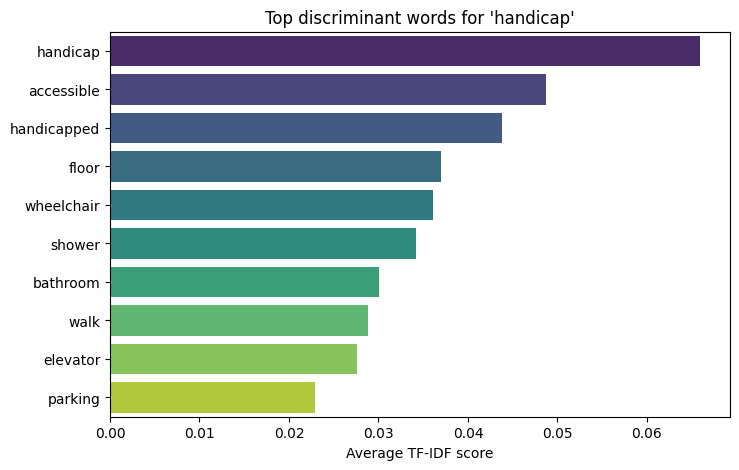

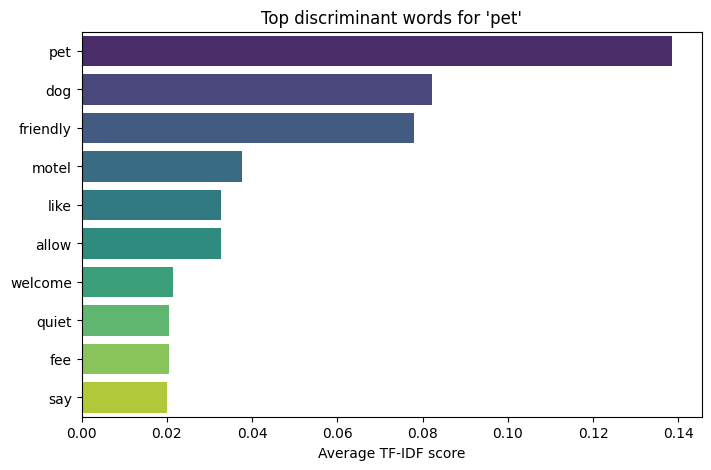

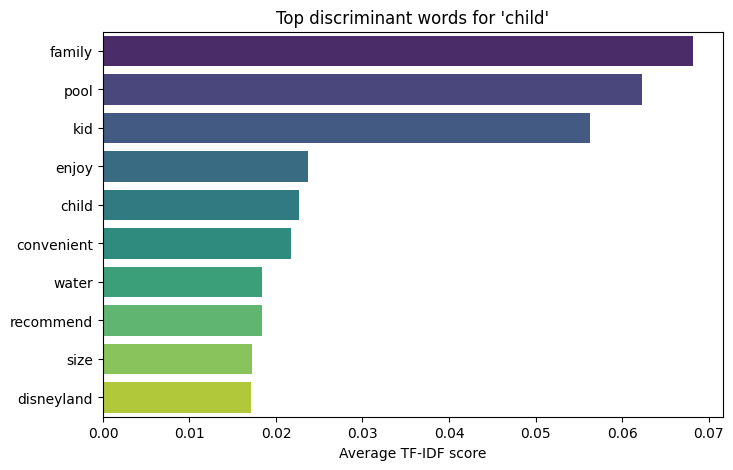

In [ ]:
for cat in discriminant_words:
    top_words = discriminant_words[cat][:10]  
    scores = [tfidf_value[cat][w] for w in top_words]
    
    df_plot = pd.DataFrame({"word": top_words, "tfidf": scores})
    plt.figure(figsize=(8, 5))
    sns.barplot(data=df_plot, x="tfidf", y="word", palette="viridis", hue="word", dodge=False, legend=False)
    plt.title(f"Top discriminant words for '{cat}'")
    plt.xlabel("Average TF-IDF score")
    plt.ylabel("")
    plt.show()


## Topic Modeling with NMF

NMF (Non-Negative Matrix Factorization) is an unsupervised technique that factorizes a matrix into two smaller matrices with only non-negative coefficients. When applied to text, it can identify topics or recurring themes in a corpus of reviews by grouping words that often appear together. This is particularly useful for highlighting the recurring needs or preferences of travelers with specials needs.


Documents per topic:
Topic 0: 113 reviews
Topic 1: 34 reviews
Topic 2: 53 reviews


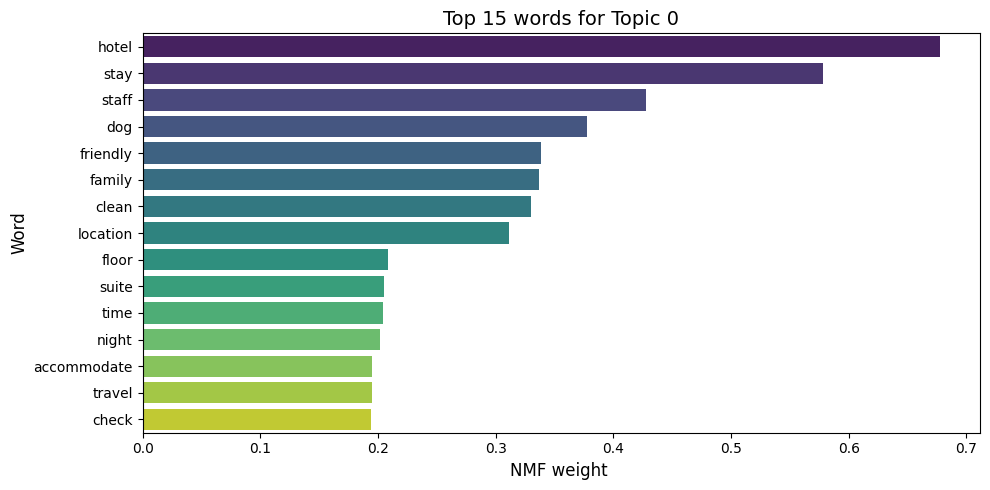

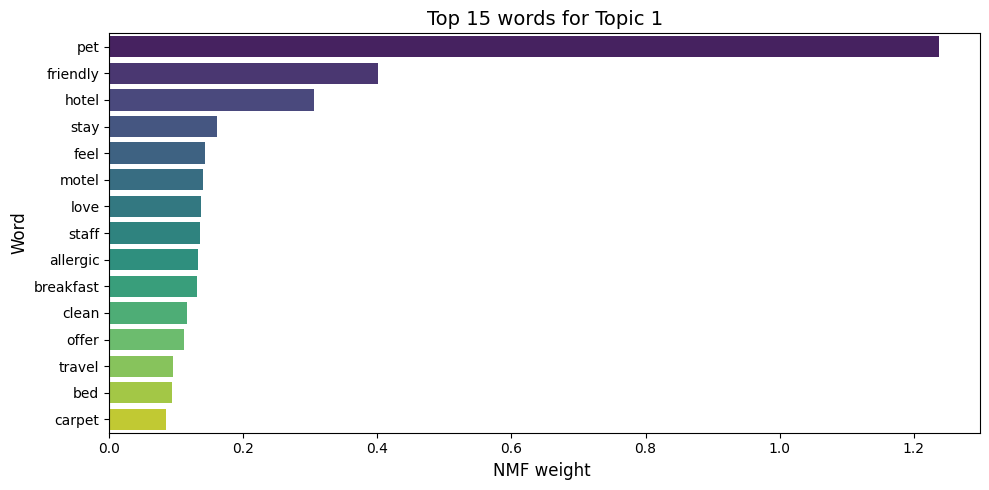

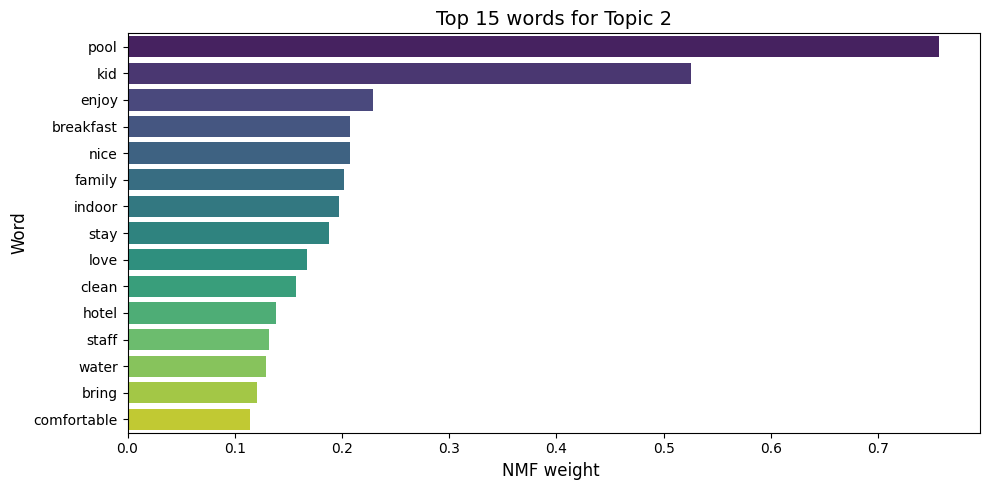

In [116]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt

reviews = df['review_lemmatized'].to_list()

# TF-IDF Vectorization
X = vectorizer.fit_transform(reviews)
feature_names = vectorizer.get_feature_names_out()

# NMF Topic Modeling
n_topics = 3  # number of topic to find
nmf_model = NMF(n_components=n_topics, random_state=42, init='nndsvda', max_iter=200)
nmf_model.fit(X)


n_top_words = 15
topics = {}

for topic_idx, topic in enumerate(nmf_model.components_):
    top_indices = topic.argsort()[::-1][:n_top_words]
    top_words = [feature_names[i] for i in top_indices]
    topics[topic_idx] = top_words


# Match each review to its main topic
doc_topic_dist = nmf_model.transform(X)  
dominant_topics = np.argmax(doc_topic_dist, axis=1)
df = df.with_columns([
    pl.Series("dominant_topic", dominant_topics)
])

# Number of documents per topics
topic_counts = (
    df.group_by("dominant_topic")  
      .len()                    
      .sort("dominant_topic")     
)
print("\nDocuments per topic:")
for row in topic_counts.iter_rows():
    topic_idx = row[0]  
    count = row[1]      
    print(f"Topic {topic_idx}: {count} reviews")

# Visualization
for topic_idx, words in topics.items():
    word_indices = [vectorizer.vocabulary_[w] for w in words]
    weights = nmf_model.components_[topic_idx][word_indices]
    df_plot = pd.DataFrame({"word": words, "weight": weights})
    df_plot = df_plot.sort_values("weight", ascending=False)

    plt.figure(figsize=(10,5))
    sns.barplot(data=df_plot, x="weight", y="word", palette="viridis")
    plt.title(f"Top {n_top_words} words for Topic {topic_idx}", fontsize=14)
    plt.xlabel("NMF weight ", fontsize=12)
    plt.ylabel("Word", fontsize=12)
    plt.tight_layout()
    plt.show()

This is simply code to monitor training and visualize whether the model has converged or not, as well as the reconstruction error. The reconstruction error has no given threshold, but it can provide information when comparing two configurations. The lower the error, the more relevant the configuration.

NMF was executed for 61 iterations (max 100)
NMF converged before reaching the maximum number of iterations.
Final reconstruction error: 13.4392


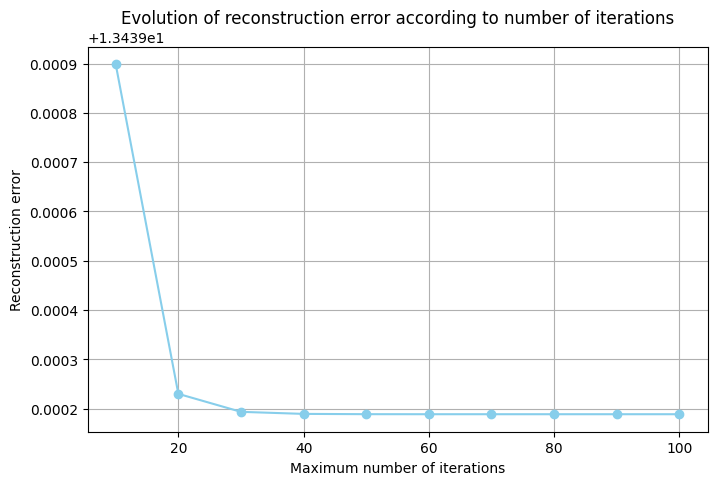

In [117]:
# Parameters
n_topics = 3
max_iter = 100 

reviews = df['review_lemmatized'].to_list()
X = vectorizer.fit_transform(reviews)

nmf_model = NMF(n_components=n_topics, random_state=42, init='nndsvda', max_iter=max_iter)
nmf_model.fit(X)

print(f"NMF was executed for {nmf_model.n_iter_} iterations (max {max_iter})")
if nmf_model.n_iter_ == max_iter:
    print("The model reached the maximum number of iterations and may not have fully converged.")
else:
    print("NMF converged before reaching the maximum number of iterations.")

print(f"Final reconstruction error: {nmf_model.reconstruction_err_:.4f}")


# Error evaluation
reconstruction_errors = []
iter_range = range(10, max_iter+1, 10)
for it in iter_range:
    nmf_temp = NMF(n_components=n_topics, random_state=42, init='nndsvda', max_iter=it)
    nmf_temp.fit(X)
    reconstruction_errors.append(nmf_temp.reconstruction_err_)

plt.figure(figsize=(8,5))
plt.plot(iter_range, reconstruction_errors, marker='o', color='skyblue')
plt.xlabel("Maximum number of iterations")
plt.ylabel("Reconstruction error")
plt.title("Evolution of reconstruction error according to number of iterations")
plt.grid(True)
plt.show()
